In [1]:
from src.plot_utils import *
import pickle
import pymannkendall as mk
from scipy.interpolate import interp1d
from scipy import stats
from tqdm import tqdm
import multiprocessing as mp
import statsmodels.api as sm
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=24)
from pathlib import Path
import json

feature = 'ImperviousSurface'
featureName = 'urban area'

Qmin7Fname = '../data/Qmin7_final_dataset_seasonal4.pkl'
Qmax7Fname = '../data/Qmax7_final_dataset_seasonal4.pkl'

par_map = pd.read_csv('../data/predictors.csv')

dir_Qmax7 = Path('../results/run_Qmax7_onlyUrban_0506_1359_seed824956/')
dir_Qmin7 = Path('../results/run_Qmin7_onlyUrban_0506_1357_seed220973/')

with open(dir_Qmax7 / 'cfg.json', 'r') as fp:
    cfg = json.load(fp)
    
mode = cfg['mode']
predictors = cfg['meteo_name'] + cfg['lulc_name'] + cfg['attr_name']
log = cfg['log']
m3s = cfg['m3s']
feature = cfg['feature']
model = cfg['model']

with open(dir_Qmin7 / 'cfg.json', 'r') as fp:
    cfg_Qmin7 = json.load(fp)
cfg_Qmax7 = cfg

### model evaluation

Qmin7 94.50052210233206 93.1894651351665
Qmax7 96.82060802970527 96.2056161522395


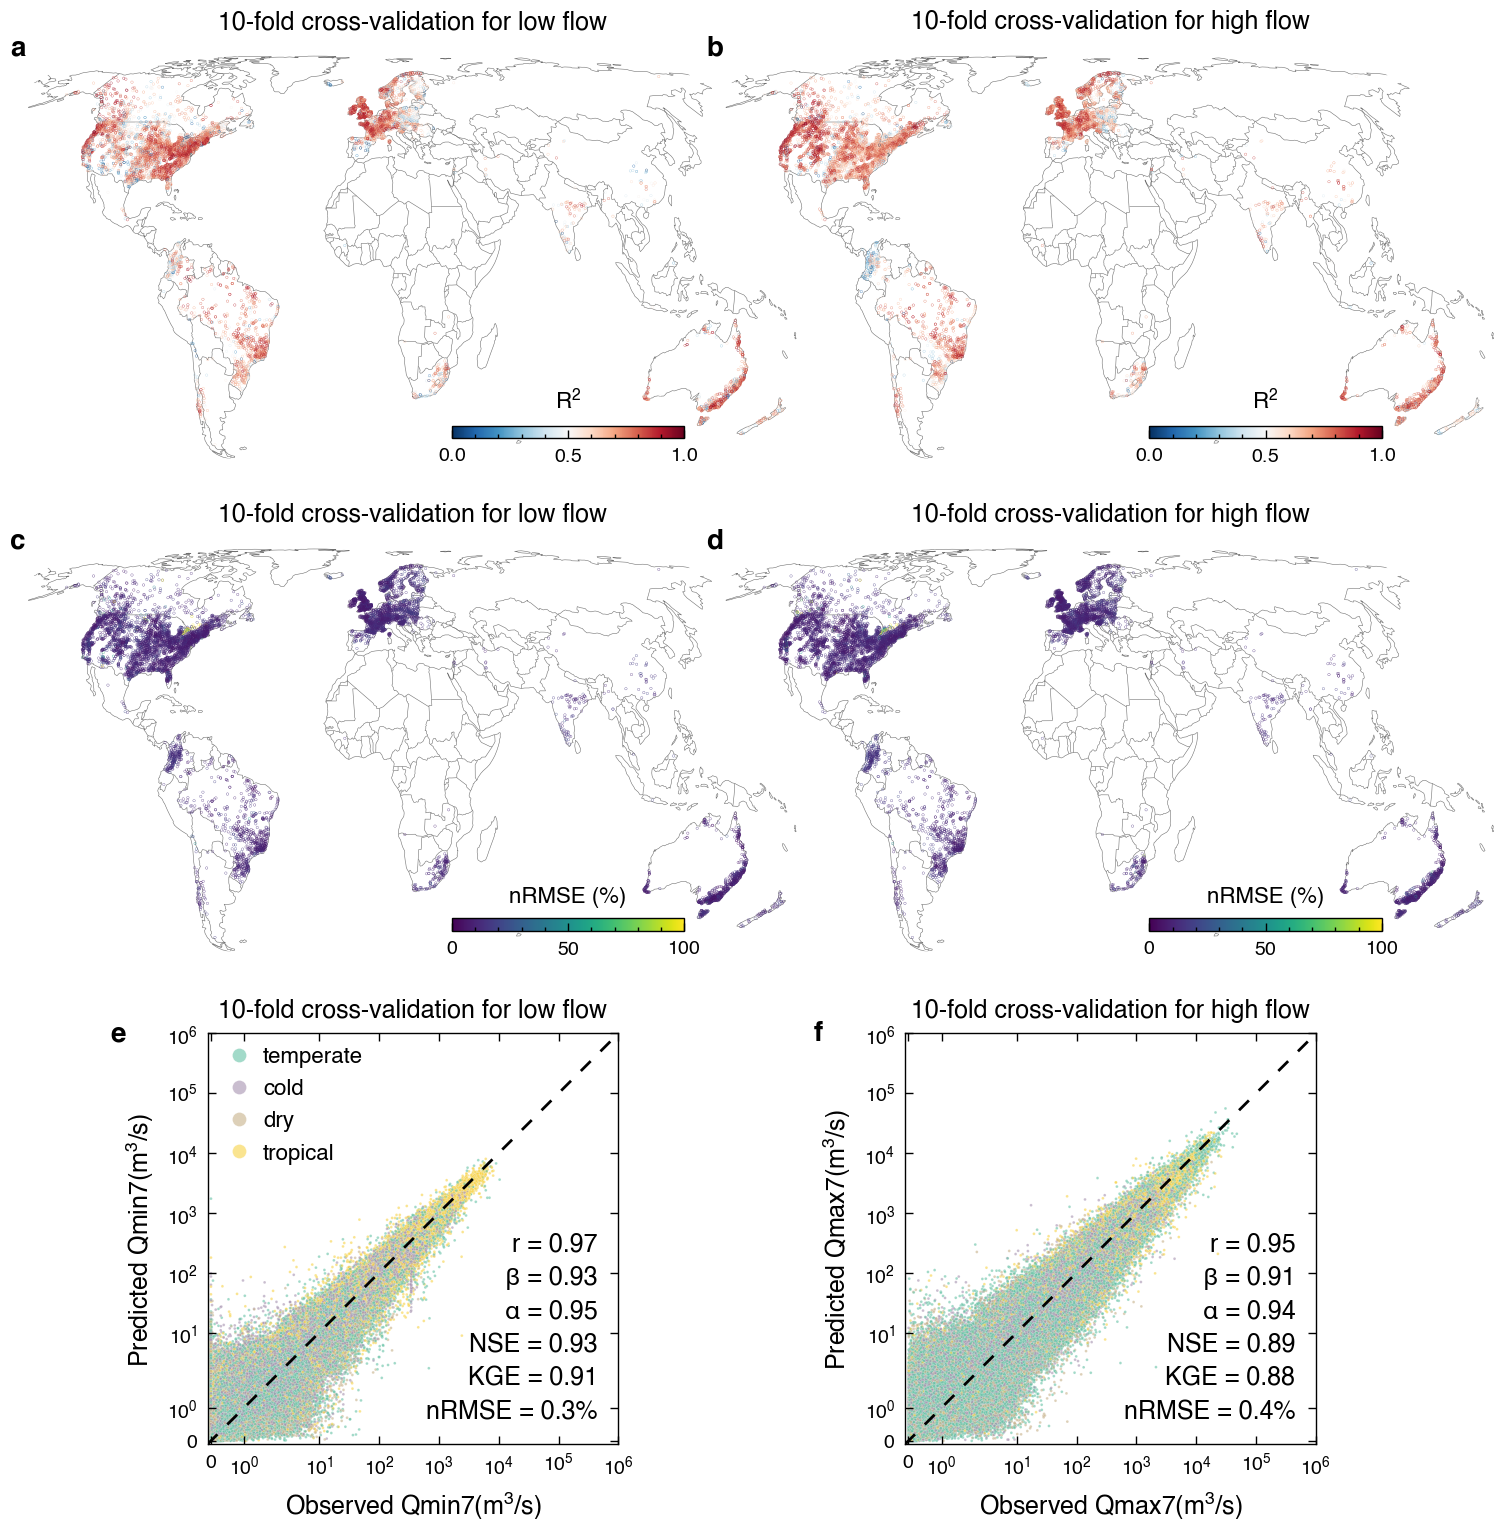

In [2]:
Qmin7Fname = dir_Qmin7 / f'{model}_{mode}_cv10_raw_result.csv'
Qmax7Fname = dir_Qmax7 / f'{model}_{mode}_cv10_raw_result.csv'

df_Qmin7 = pd.read_csv(Qmin7Fname)
df_Qmax7 = pd.read_csv(Qmax7Fname)

df_Qmin7['Qmin7date'] = pd.to_datetime(df_Qmin7['Qmin7date'])
df_Qmax7['Qmax7date'] = pd.to_datetime(df_Qmax7['Qmax7date'])

df_Qmin7_obs = pd.read_pickle(cfg_Qmin7['fname'])
df_Qmax7_obs = pd.read_pickle(cfg_Qmax7['fname'])

df_Qmin7 = df_Qmin7.merge(df_Qmin7_obs, on = ['ohdb_id','Qmin7date'])
df_Qmax7 = df_Qmax7.merge(df_Qmax7_obs, on = ['ohdb_id','Qmax7date'])

Qmin7Fname = dir_Qmin7 / f'{model}_{mode}_cv10_station_based_result.csv'
Qmax7Fname = dir_Qmax7 / f'{model}_{mode}_cv10_station_based_result.csv'

df_Qmin7_sta = pd.read_csv(Qmin7Fname)
df_Qmax7_sta = pd.read_csv(Qmax7Fname)

df_Qmin7_sta['R2'] = df_Qmin7_sta.r.values ** 2
df_Qmax7_sta['R2'] = df_Qmax7_sta.r.values ** 2

fig, ax1 = plt.subplots(figsize = (5,3), subplot_kw = {'projection':ccrs.EqualEarth()},dpi=200)
ax2 = ax1.inset_axes([.9, 0, 1, 1], projection =  ccrs.EqualEarth())
ax2.set_facecolor('none')
ax1_1 = ax1.inset_axes([0, -1.2, 1, 1], projection = ccrs.EqualEarth())
ax2_1 = ax1_1.inset_axes([.9, 0, 1, 1], projection =  ccrs.EqualEarth())
ax2_1.set_facecolor('none')
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
        legend = False
        name1 = 'low flow'
    else:
        df = df_Qmax7.copy()
        legend = True
        name1 = 'high flow'
    df_sta = eval('df_'+name+'_sta')
    
    title = f'10-fold cross-validation for {name1}'
    lons = df_sta.ohdb_longitude.values
    lats = df_sta.ohdb_latitude.values
    
    # R2
    ax = eval('ax'+str(i+1))
    vals = df_sta.R2.values
    label = '$\mathregular{R^2}$'
    cmap = plt.cm.RdBu_r
    _,ras = plot_map(ax, lons, lats, vals, 0, 1, 0.1, cmap, title, label, marker = "$\circ$", size = 1, fontSize = 9, norm = None, addHist = False)
    cax = ax.inset_axes([.55, 0.05, .3, .03])
    fig.colorbar(ras, cax = cax, orientation = 'horizontal')
    cax.set_title(label, fontsize = 8)
    
    # nRMSE
    ax = eval('ax'+str(i+1)+'_1')
    vals = df_sta.nRMSEminmax.values
    label = 'nRMSE (%)'
    cmap = plt.cm.viridis
    _,ras = plot_map(ax, lons, lats, vals, 0, 100, 10, cmap, title, label, marker = "$\circ$", size = 1, fontSize = 9, norm = None, addHist = False)
    cax = ax.inset_axes([.55, 0.05, .3, .03])
    fig.colorbar(ras, cax = cax, orientation = 'horizontal')
    cax.set_title(label, fontsize = 8)
    
    print(name, df_sta.loc[df_sta.R2>=0.3,:].shape[0] / df_sta.shape[0] * 100, 
         df_sta.loc[df_sta.KGE>=0.3,:].shape[0] / df_sta.shape[0] * 100)
    
ax3 = ax1_1.inset_axes([0, -1.2, 1, 1])
ax4 = ax2_1.inset_axes([0, -1.2, 1, 1])
df_Qmin70 = df_Qmin7
plot_scatter(df_Qmin70.Q.values, 
            df_Qmin70['pred'].values, 
            df_Qmin70.climate_label.values, 
            'Observed Qmin7' + '($\mathregular{m^3/s}$)', 
            'Predicted Qmin7' +  '($\mathregular{m^3/s}$)', 
            normColor = 'norm',
            palette = palette,
            fontsize = 9,
            size = 1,
            ax = ax3)
ax3.set_title('10-fold cross-validation for low flow', fontsize = 9)

df_Qmax70 = df_Qmax7
plot_scatter(df_Qmax70.Q.values, 
            df_Qmax70['pred'].values, 
            df_Qmax70.climate_label.values, 
            'Observed Qmax7' + '($\mathregular{m^3/s}$)', 
            'Predicted Qmax7' +  '($\mathregular{m^3/s}$)', 
            normColor = 'norm',
            palette = palette,
            fontsize = 9,
            legend = False,
            size = 1,
            ax = ax4)
sns.move_legend(ax3, 'upper left', bbox_to_anchor = (0, .99), markerscale = 5, fontsize = 8, handletextpad = .1, borderaxespad = 0)
ax4.set_title('10-fold cross-validation for high flow', fontsize = 9)

for i,ax in enumerate([ax1, ax2, ax1_1, ax2_1]):
    ax.text(0, 1, string.ascii_letters[i], weight = 'bold', ha = 'right', va = 'center', fontsize = 10, transform = ax.transAxes)
for i,ax in enumerate([ax3, ax4]):
    ax.text(-.2, 1, string.ascii_letters[i+4], weight = 'bold', ha = 'right', va = 'center', fontsize = 10, transform = ax.transAxes)
    # set axis limits
    ax.set_xlim(-.1, 1e6)
    ax.set_ylim(-.1, 1e6)

fig.savefig(dir_Qmax7 / f'figure_scatter_and_R2_map_{mode}.png', dpi = 600)

### SHAP feature importance

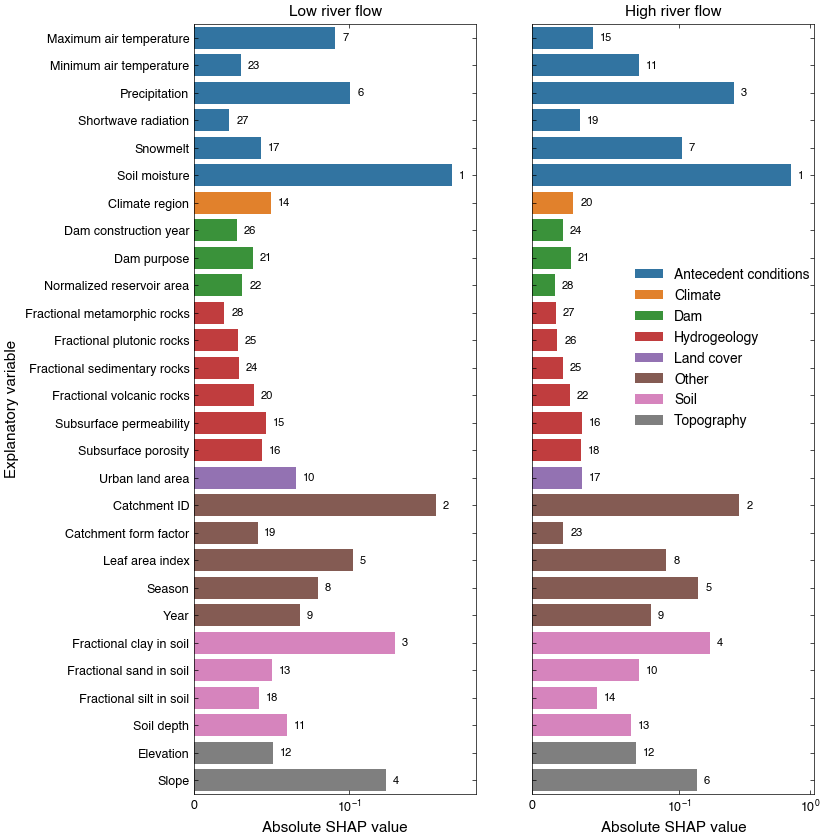

In [3]:
# load shap and predictors
Qmax7_fname = dir_Qmax7 / f'{model}_{mode}_shap_values.pkl'
shap_Qmax7 = pickle.load(open(Qmax7_fname, 'rb'))
Qmin7_fname = dir_Qmin7 / f'{model}_{mode}_shap_values.pkl'
shap_Qmin7 = pickle.load(open(Qmin7_fname, 'rb'))

if mode == 'noLULC':
    predictors1 = [item for item in predictors if item not in ['ImperviousSurface', 'forest', 'crop', 'grass', 'water', 'wetland']]
elif mode == 'onlyUrban':
    predictors1 = [item for item in predictors if item not in ['forest', 'crop', 'grass', 'water', 'wetland']]

df_shap_Qmax7 = pd.DataFrame(data = shap_Qmax7, columns = predictors1)
df_shap_Qmin7 = pd.DataFrame(data = shap_Qmin7, columns = predictors1)

fig, axes = plt.subplots(1, 2, figsize = (8, 10), sharey = True)
for i,name in enumerate(['Qmin7','Qmax7']):
    shap = eval('df_shap_'+name)
    shap = shap.abs().mean()
    shap.name = 'SHAP'
    shap = shap.reset_index()
    shap['name'] = shap['index'].apply(lambda x:par_map.loc[par_map.par==x,'name'].values[0])
    shap['type'] = shap['index'].apply(lambda x:par_map.loc[par_map.par==x,'type'].values[0])
    shap = shap.sort_values(['type','name'])
    # reoder Antecedent conditions
    shap1 = shap.loc[shap.type=='Antecedent conditions',:]
    shap1['tmp'] = shap1.name.apply(lambda x:int(x.split('-')[0]) if '-day' in x else 99)
    shap1 = shap1.sort_values('tmp').drop(columns=['tmp'])
    shap2 = shap.loc[shap.type!='Antecedent conditions',:]
    shap = pd.concat([shap1, shap2])
    shap['rank'] = shap['SHAP'].rank(ascending = False).astype(int).astype(str)
    shap = shap.reset_index()
    if i == 1:
        legend = True
    else:
        legend = False
    sns.barplot(shap, x = 'SHAP', y = 'name', hue = 'type', ax = axes[i], legend = legend, palette = 'tab10')
    if name == 'Qmin7':
        name2 = 'Low river flow'
    else:
        name2 = 'High river flow'
    axes[i].set_title(name2, fontsize = 11)
    axes[i].set_ylabel('Explanatory variable', fontsize = 11)
    axes[i].set_xlabel('Absolute SHAP value', fontsize = 11)
    axes[i].set_xscale('symlog', linthresh=0.1)
    axes[i].yaxis.set_minor_locator(ticker.NullLocator())

    patches = axes[i].patches
    handles, labels = axes[i].get_legend_handles_labels()
    patches = [s for s in patches if s not in handles]
    tmp = []
    for s,a in enumerate(patches):
        rank0 = shap.iloc[s,:]['rank']
        axes[i].annotate(rank0, (a.get_width(), a.get_y()+a.get_height()/2),
                        ha='left', va='center', xytext=(5, 0),
                        textcoords='offset points', fontsize=8,)
        tmp.append(a.get_width())
    axes[i].set_xlim(0, np.max(tmp)*1.5)
    axes[i].tick_params(axis='both', labelsize = 9)
sns.move_legend(axes[1], loc = 'upper left', bbox_to_anchor = (.32, .7), title = None, fontsize = 10)

fig.savefig(dir_Qmax7 / f'figure_shap_feature_importance_{mode}.png', dpi = 600)


### SHAP dependence plot

In [5]:
# load shap and predictors
Qmax7_fname = dir_Qmax7 / f'{model}_{mode}_shap_values.pkl'
shap_Qmax7 = pickle.load(open(Qmax7_fname, 'rb'))
Qmin7_fname = dir_Qmin7 / f'{model}_{mode}_shap_values.pkl'
shap_Qmin7 = pickle.load(open(Qmin7_fname, 'rb'))

if mode == 'noLULC':
    predictors1 = [item for item in predictors if item not in ['ImperviousSurface', 'forest', 'crop', 'grass', 'water', 'wetland']]
elif  mode == 'onlyUrban':
    predictors1 = [item for item in predictors if item not in ['forest', 'crop', 'grass', 'water', 'wetland']]

df_shap_Qmax7 = pd.DataFrame(data = shap_Qmax7, columns = predictors1)
df_shap_Qmin7 = pd.DataFrame(data = shap_Qmin7, columns = predictors1)

par_map = pd.read_csv('../data/predictors.csv')

df_Qmin7 = pd.read_pickle(cfg_Qmin7['fname'])
df_Qmax7 = pd.read_pickle(cfg_Qmax7['fname'])
df_Qmin7['shap'] = df_shap_Qmin7['ImperviousSurface'].copy()
df_Qmax7['shap'] = df_shap_Qmax7['ImperviousSurface'].copy()

df_Qmin7['catch'] = np.where(df_Qmin7.aridity<=0.65, 'dry', 'wet')
df_Qmax7['catch'] = np.where(df_Qmax7.aridity<=0.65, 'dry', 'wet')

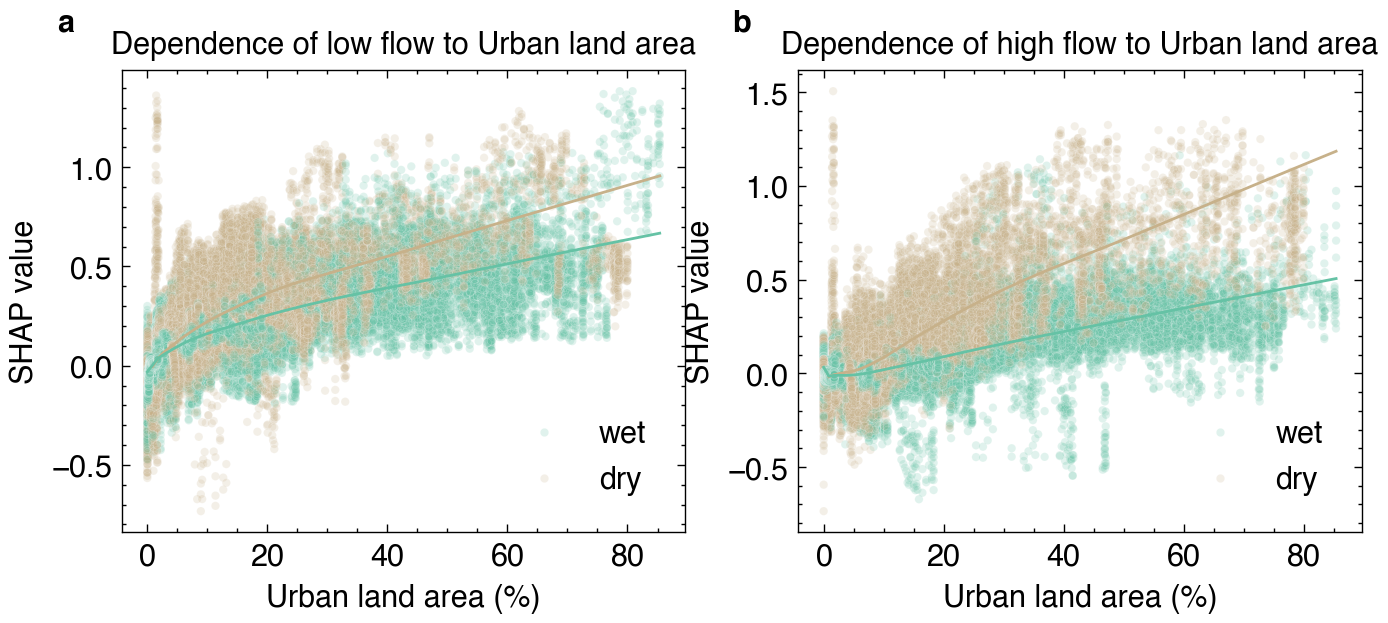

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3), dpi = 200)
palette0 = {'dry':'#C7B18A', 'wet':"#65C2A5"}
sns.scatterplot(df_Qmin7, x = feature, y = 'shap', hue = 'catch', ax = ax1, alpha = .2, palette = palette0)
sns.scatterplot(df_Qmax7, x = feature, y = 'shap', hue = 'catch', ax = ax2, alpha = .2, palette = palette0)

import statsmodels.api as sm
for i,name in enumerate(['Qmin7','Qmax7']):
    ax = eval('ax'+str(i+1))
    featureName = par_map.loc[par_map.par==feature,'name'].values[0]
    ax.set_xlabel(featureName.capitalize()+' (%)', fontsize = 11)
    ax.set_ylabel('SHAP value', fontsize = 11)
    sns.move_legend(ax, 'lower right', bbox_to_anchor = (.98, .02), title = None, fontsize = 11)
    if i == 0:
        ax.set_title('Dependence of low flow to '+featureName, fontsize = 11)
    else:
        ax.set_title('Dependence of high flow to '+featureName, fontsize = 11)
    ax.tick_params(axis = 'both', labelsize = 11)

    # estimate LOWESS
    df0 = eval('df_'+name)
    xvals = np.linspace(df0[feature].min(), df0[feature].max(), 100)
    ps = []
    for catch in ['dry','wet']:
        lowess0 = sm.nonparametric.lowess(
            df0.loc[df0.catch==catch,'shap'].values, 
            df0.loc[df0.catch==catch,feature].values, 
            xvals=xvals, 
            frac=0.1, 
            return_sorted = True)   
        p0 = ax.plot(xvals, lowess0, color = palette0[catch], lw = 1, label = catch + ' climate')
        ps.append(p0)
    
    # legend
    line1 = Line2D([], [], color=palette['dry'], ls="-", linewidth=1.5)
    line2 = Line2D([], [], color=palette['wet'], ls="-", linewidth=1.5)
    sc1 = plt.scatter([],[], s=15, facecolors=palette['dry'], edgecolors=palette['dry'])
    sc2 = plt.scatter([],[], s=15, facecolors=palette['wet'], edgecolors=palette['wet'])
    ax.legend([(sc1,line1), (sc2,line2)], ['Catchments in dry climate','Catchments in wet climate'], numpoints=1, handlelength = 1)

    ax.text(-.1, 1.1, ['a','b'][i], weight = 'bold', ha = 'center', va = 'center', transform = ax.transAxes, fontsize = 11)

fig.savefig(dir_Qmax7 / f'figure_shap_dependence_{feature}_{mode}.png', dpi = 600)

### SHAP feature ranking of urban area for each catchment

In [12]:
# load shap and predictors
Qmax7_fname = dir_Qmax7 / f'{model}_{mode}_shap_values.pkl'
shap_Qmax7 = pickle.load(open(Qmax7_fname, 'rb'))
Qmin7_fname = dir_Qmin7 / f'{model}_{mode}_shap_values.pkl'
shap_Qmin7 = pickle.load(open(Qmin7_fname, 'rb'))

if mode == 'noLULC':
    predictors1 = [item for item in predictors if item not in ['ImperviousSurface', 'forest', 'crop', 'grass', 'water', 'wetland']]
elif mode == 'onlyUrban':
    predictors1 = [item for item in predictors if item not in ['forest', 'crop', 'grass', 'water', 'wetland']]

shap_Qmax7 = pd.DataFrame(data = shap_Qmax7, columns = predictors1)
shap_Qmin7 = pd.DataFrame(data = shap_Qmin7, columns = predictors1)

df_Qmin7 = pd.read_pickle(cfg_Qmin7['fname'])
df_Qmax7 = pd.read_pickle(cfg_Qmax7['fname'])

df_Qmin7 = df_Qmin7[["ohdb_id", "ohdb_longitude", "ohdb_latitude", 'climate_label', 'aridity']]
df_Qmax7 = df_Qmax7[["ohdb_id", "ohdb_longitude", "ohdb_latitude", 'climate_label', 'aridity']]

df_Qmin7 = df_Qmin7.rename(columns={'ohdb_longitude':'lon','ohdb_latitude':'lat'})
df_Qmax7 = df_Qmax7.rename(columns={'ohdb_longitude':'lon','ohdb_latitude':'lat'})

shap_Qmin7 = pd.concat([df_Qmin7, shap_Qmin7], axis = 1)
shap_Qmax7 = pd.concat([df_Qmax7, shap_Qmax7], axis = 1)


<LAMBDA> DONE:   0%|          | 0/8619 [00:00<?, ?it/s]

<LAMBDA> DONE:   0%|          | 0/8619 [00:00<?, ?it/s]

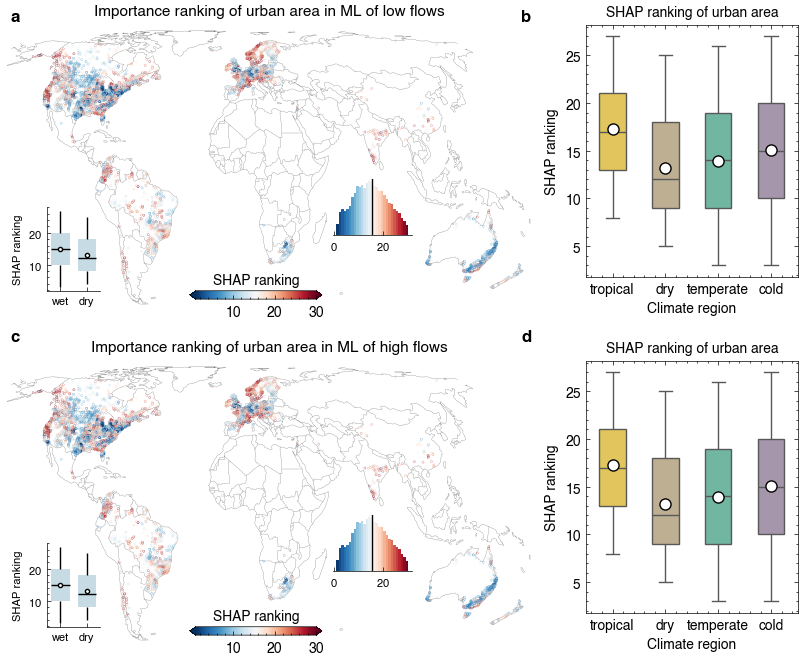

In [13]:
feature = cfg_Qmax7['feature']

shap_Qmin7_ave = shap_Qmin7.groupby(['ohdb_id','lon','lat','climate_label','aridity'], group_keys=False).p_apply(
    lambda x: pd.Series(
        [x.iloc[:,5:].abs().mean(0).rank(ascending=False, method='min').loc[feature], x[feature].abs().mean()],
        index = [feature+'_rank', feature+'_shap']
    )
).reset_index()
shap_Qmax7_ave = shap_Qmin7.groupby(['ohdb_id','lon','lat','climate_label','aridity'], group_keys=False).p_apply(
    lambda x: pd.Series(
        [x.iloc[:,5:].abs().mean(0).rank(ascending=False, method='min').loc[feature], x[feature].abs().mean()],
        index = [feature+'_rank', feature+'_shap']
    )
).reset_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 8), subplot_kw = {'projection':ccrs.EqualEarth()})
plt.subplots_adjust(hspace = .2)
ax1.set_facecolor('none')
ax2.set_facecolor('none')
for i,name in enumerate(['Qmin7','Qmax7']):
    ax = eval('ax'+str(i+1))
    df = eval('shap_'+name+'_ave')
    lons = df.lon.values
    lats = df.lat.values
    vals = df[feature+'_rank'].values

    vmin, vmax, vind = 1, shap_Qmin7.shape[1]-5, 1
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)
    if i == 0:
        title = f'Importance ranking of {featureName.lower()} in ML of low flows'
    else:
        title = f'Importance ranking of {featureName.lower()} in ML of high flows'
    label = f'SHAP ranking'
    _, ras = plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, label, norm = norm, fontSize = 11, size = 3)
    # add colorbar
    cax = ax.inset_axes([.35, .02, 0.25, .03])
    cbar = plt.colorbar(ras, cax = cax, orientation = 'horizontal', extend = 'both')
    cax.tick_params(labelsize = 10)
    cax.set_title(label, size = 10, pad = 5)
    # add boxplot to show the impact for dry (AI<1) and wet (AI>1) catchments
    df['tmp'] = np.where(df['aridity']>0.65, 'wet', 'dry')

    axin = ax.inset_axes([0.08, .05, .1, .3])
    sns.boxplot(df, 
                x = 'tmp', y = feature+'_rank', ax = axin, 
                showfliers = False, width = .7, 
                whis = [5, 95],
                color = '#c2dcea',
                showmeans = True,
                capprops = {'linewidth': 0},
                boxprops={'edgecolor': 'none'},  # No edge line
                meanprops={'marker': 'o',
                       'markerfacecolor': 'white',
                       'markeredgecolor': 'black',
                       'markersize': '3'},
                medianprops={'color': 'black', 'linewidth': 1},  # Black median line
                whiskerprops={'color': 'black', 'linewidth': 1},  # Black whiskers
               )
    axin.set_facecolor('none')
#     axin.set_yticks([0,9])
    axin.set_xlabel(None)
    axin.set_ylabel(f'SHAP ranking', fontsize = 8)
    axin.tick_params(labelsize = 8,  which='both', top = False, right = False)
    axin.xaxis.set_minor_locator(ticker.NullLocator())
    axin.spines["top"].set_visible(False) 
    axin.spines["right"].set_visible(False) 

# # add title
# ax1.set_title(f'Impact of +10pp {featureName.lower()} on low flow', fontsize = 10)
# ax2.set_title(f'Impact of +10pp {featureName.lower()} on low flow', fontsize = 10)   

ax3 = ax1.inset_axes([1.1, .1, .4, .9])
ax4 = ax2.inset_axes([1.1, .1, .4, .9])
for i,name in enumerate(['Qmin7','Qmax7']):
    ax0 = [ax3,ax4][i]
    df0 = eval('shap_'+name+'_ave')
    sns.boxplot(data = df0, x = 'climate_label', y = feature+'_rank', hue = 'climate_label', 
                showfliers = False, showmeans = True, width = .5, 
                whis = [5, 95],
                meanprops={'marker': 'o',
                           'markerfacecolor': 'white',
                           'markeredgecolor': 'black',
                           'markersize': '8'},
                ax = ax0, palette = palette)
    ax0.set_xlabel('Climate region', fontsize = 10)
    ax0.set_ylabel(f'SHAP ranking', fontsize = 10)
    ax0.tick_params(axis = 'both', labelsize = 10)
    # sns.move_legend(ax2, 'upper left', title = None, fontsize = 10)
    ax0.set_title(f'SHAP ranking of urban area', fontsize = 10)

# add subplot order
fig.text(.15, .9, 'a', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.88, .9, 'b', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.15,  .5, 'c', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.88,  .5, 'd', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)

fig.savefig(dir_Qmax7 / f'figure_shap_ranking_map_bobxplot_{mode}.png', dpi = 600)

# Revert back plotting style
plt.rcParams.update(plt.rcParamsDefault)  # Reset to default Matplotlib settings
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')

# Re-enable inline plotting for Jupyter
%matplotlib inline

<Axes: xlabel='ImperviousSurface_rank', ylabel='aridity'>

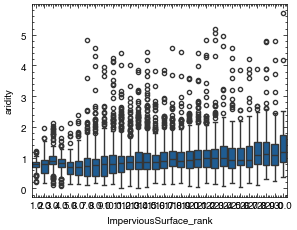

In [17]:
sns.boxplot(shap_Qmin7_ave, x = 'ImperviousSurface_rank', y = 'aridity')

### Spearman correlation between urban area and other features

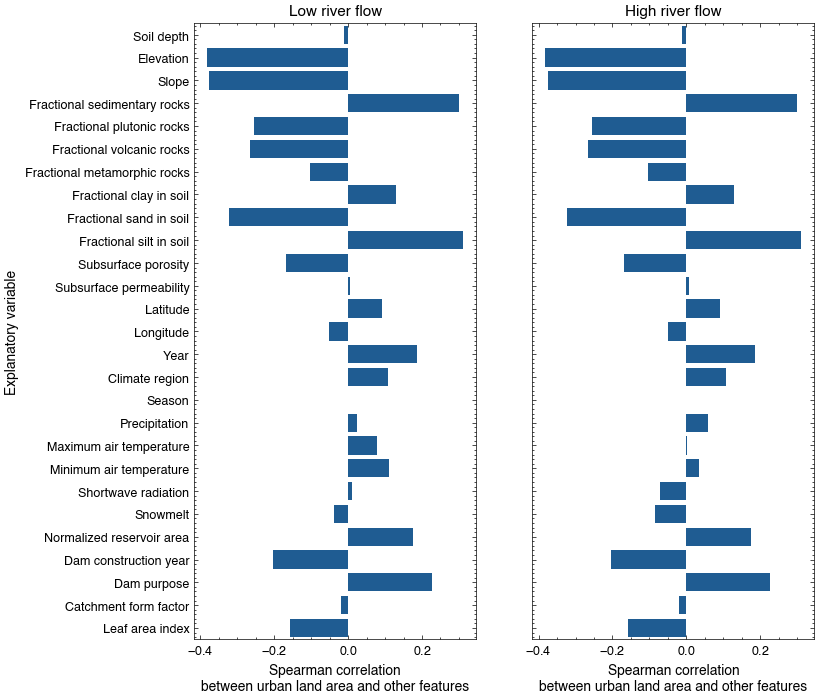

In [8]:
feature = 'ImperviousSurface'
featureName = par_map.loc[par_map.par==feature,'name'].values[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,8), sharey = True)
for i,name in enumerate(['Qmin7','Qmax7']):
    df0 = eval('df_'+name)
    if name == 'Qmin7':
        predictors0 = [item+'_30' if item in ['p', 'tmax', 'tmin', 'swd', 'snowmelt', 'smrz'] else item for item in predictors]
    else:
        predictors0 = [item+'_7' if item in ['p', 'tmax', 'tmin', 'swd', 'snowmelt', 'smrz'] else item for item in predictors]
    corr0 = df0[predictors0].corr(method = 'spearman')
    corr0 = corr0.loc[corr0.index!=feature,feature].reset_index()
    corr0['index'] = corr0['index'].apply(lambda x:par_map.loc[par_map.par==x,'name'].values[0])
    corr0['index'] = corr0['index'].apply(lambda x:re.sub(r'(\d+)-day','',x))
    corr0['index'] = corr0['index'].apply(lambda x:x.strip().capitalize())
    ax = eval('ax'+str(i+1))
    sns.barplot(corr0, y = 'index', x = feature, ax = ax)
    if name == 'Qmin7':
        ax.set_title('Low river flow', fontsize = 11)
    else:
        ax.set_title('High river flow', fontsize = 11)
    ax.set_xlabel(f'Spearman correlation\nbetween {featureName.lower()} and other features', fontsize = 10)
    ax.set_ylabel('Explanatory variable', fontsize = 10)
    ax.tick_params(axis='both', labelsize = 9)
fig.savefig(f'../picture/spearman_correlation_between_{feature}_and_others_{outName}.png', dpi = 600)


### PDP or ALE plots

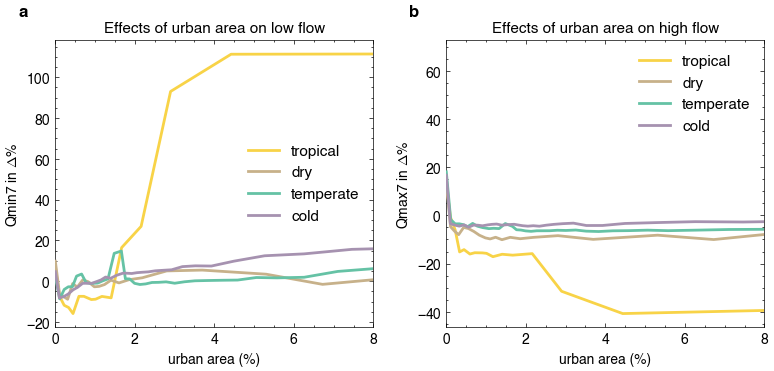

In [8]:
purpose = 'ale'
min_interval = 0.1
even = False
monte = False

Qmin7Fname = dir_Qmin7 / f'{model}_{mode}_{purpose}_{feature}_min_interval_{min_interval}.csv'
Qmax7Fname = dir_Qmax7 / f'{model}_{mode}_{purpose}_{feature}_min_interval_{min_interval}.csv'

if even:
    Qmin7Fname = str(Qmin7Fname)[:-4] + '_even.csv'
    Qmax7Fname = str(Qmax7Fname)[:-4] + '_even.csv'

df_eff_Qmin7 = pd.read_csv(Qmin7Fname)
df_eff_Qmax7 = pd.read_csv(Qmax7Fname)

if not monte:
    df_eff_Qmin7 = df_eff_Qmin7.loc[df_eff_Qmin7.monte==0,:]
    df_eff_Qmax7 = df_eff_Qmax7.loc[df_eff_Qmax7.monte==0,:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
for i,name in enumerate(['Qmin7','Qmax7']):
    df = eval('df_eff_'+name)
    ax = eval('ax'+str(i+1))
    for climate in ['tropical','dry','temperate','cold']:
        tmp = df.loc[df.climate==climate,:]
        if monte:
            # Find common x-axis range
            min_x = tmp[feature].min()
            max_x = tmp[feature].max()

            groupName = 'fold' if purpose.startswith('cv') else 'monte'
            n_sample = tmp.groupby([groupName])['eff'].count().min()
            x_range = np.linspace(min_x, max_x, n_sample)  # Adjust number of points as needed

            # Interpolate each group to common x-axis
            interpolated_data = {}
            for group in tmp[groupName].unique():
                group_df =tmp[tmp[groupName] == group]
                f = interp1d(group_df[feature], group_df['eff'], kind='linear', fill_value='extrapolate')
                interpolated_data[group] = pd.DataFrame({'x': x_range, 'y': f(x_range), 'group': group})

            # Concatenate interpolated data
            interpolated_df = pd.concat(interpolated_data.values())

            # Calculate average y values for each x
            df_avg = interpolated_df.groupby('x').apply(
                lambda x: pd.Series([x.y.mean(), x.y.quantile(.025), x.y.quantile(.975)], index = ['ave','low','upp'])
            ).reset_index()

            # Create the lineplot with individual lines
            ax.plot(df_avg.x.values, df_avg.ave.values, color = palette[climate], lw = 2, label = climate, zorder = 3)
            ax.fill_between(
                df_avg.x.values, 
                df_avg.low.values, 
                df_avg.upp.values, 
                color = palette[climate], 
                ec = 'none',
                alpha = .3)
        else:
            ax.plot(tmp[feature].values, tmp.eff.values, color = palette[climate], lw = 2, label = climate, zorder = 3)
        ax.legend(fontsize = 11)
    ax.set_xlabel(f'{featureName} (%)', fontsize = 10)
    ax.set_ylabel(f'{name} in $\Delta$%', fontsize = 10)
    ax.set_xlim(0, 8)
    if i == 0:
        ax.set_title(f'Effects of {featureName.lower()} on low flow', fontsize = 11)
    else:
        ax.set_title(f'Effects of {featureName.lower()} on high flow', fontsize = 11)
    ax.tick_params(labelsize=10)
    ax.text(-.1, 1.1, ['a','b'][i], weight = 'bold', ha = 'center', va = 'center', transform = ax.transAxes, fontsize = 12)
fig.tight_layout()

if even:
    outName = dir_Qmax7 / f'figure_{purpose}_{feature}_{mode}_min_interval_{min_interval}_even.png'
else:
    outName = dir_Qmax7 / f'figure_{purpose}_{feature}_{mode}_min_interval_{min_interval}.png'
fig.savefig(outName, dpi = 600)


### sensitivity of +10% feature (map and boxplots)

fraction of significant gauges: 93.31014492753623
average diff of significant gauges: 27.769903149441024
12.33035788175072 23.068698384855228
62.24944638129147 136.21480010767883
TtestResult(statistic=-27.985931491814206, pvalue=4.859854653920578e-165, df=8623.0) -2.164104097143584
fraction of significant gauges: 88.23051948051948
average diff of significant gauges: 2.4536000618589244
-3.550528964483795 19.348062790505132
17.511661118727996 30.501074846177264
TtestResult(statistic=-37.96759475667771, pvalue=8.010836699784067e-292, df=8622.0) -1.0886809688336205


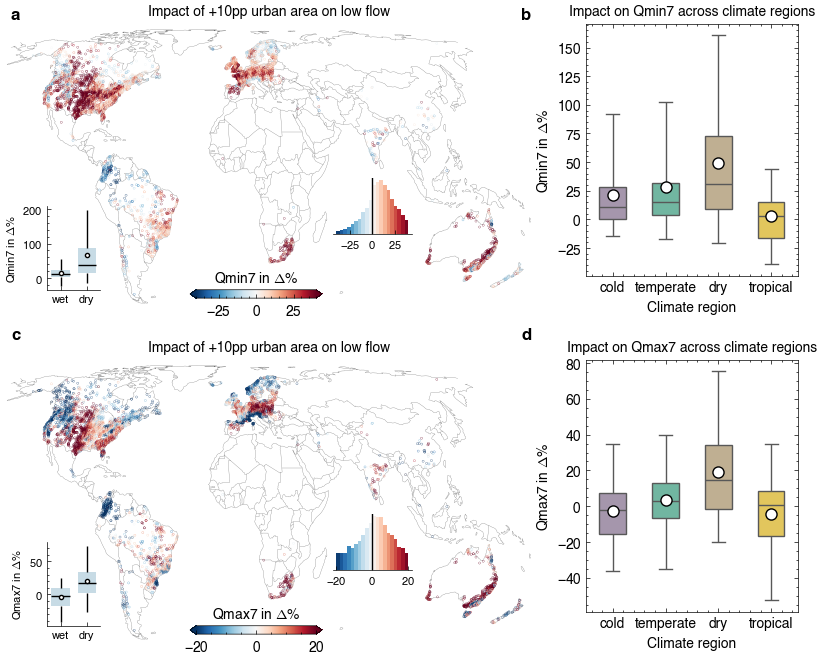

In [38]:
delta_feature = 10

Qmin7Fname = dir_Qmin7 / f'{model}_{mode}_sensitivity_func_+0{delta_feature}{feature}_diff_in_percentage.csv'
Qmax7Fname = dir_Qmax7 / f'{model}_{mode}_sensitivity_func_+0{delta_feature}{feature}_diff_in_percentage.csv'

diff_Qmin7 = pd.read_csv(Qmin7Fname)
diff_Qmax7 = pd.read_csv(Qmax7Fname)

diff_Qmin7['Qmin7date'] = pd.to_datetime(diff_Qmin7['Qmin7date'])
diff_Qmax7['Qmax7date'] = pd.to_datetime(diff_Qmax7['Qmax7date'])

diff_Qmin7 = pd.read_pickle(cfg_Qmin7['fname']).merge(diff_Qmin7, on = ['ohdb_id','Qmin7date'])
diff_Qmax7 = pd.read_pickle(cfg_Qmax7['fname']).merge(diff_Qmax7, on = ['ohdb_id','Qmax7date'])

diff_Qmin7_ave = diff_Qmin7.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity'])['diff'].agg(
    diff = lambda x:x.mean(),
    p = lambda x: stats.ttest_1samp(x, 0, alternative='two-sided').pvalue
).reset_index()
diff_Qmax7_ave = diff_Qmax7.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity'])['diff'].agg(
    diff = lambda x:x.mean(),
    p = lambda x: stats.ttest_1samp(x, 0, alternative='two-sided').pvalue
).reset_index()

# Revert back plotting style
plt.rcParams.update(plt.rcParamsDefault)  # Reset to default Matplotlib settings
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')

# Re-enable inline plotting for Jupyter
%matplotlib inline

def compute_effsize(expGroup, controlGroup, eftype = 'cohen'):
    n1, n2 = len(expGroup), len(controlGroup)
    MAD1 = 1.4826 * np.median(np.abs(expGroup-np.median(expGroup)))
    MAD2 = 1.4826 * np.median(np.abs(controlGroup-np.median(controlGroup)))
    pooled_std = np.sqrt(((n1 - 1) * MAD1 ** 2 + (n2 - 1) * MAD2 ** 2) / (n1 + n2 - 2))
    if eftype == 'cohen':
        # d = np.mean(expGroup - controlGroup) / np.sqrt((MAD1**2+MAD2**2)/2)
        # d = np.mean(expGroup - controlGroup) / pooled_std
        d = (np.mean(expGroup) - np.mean(controlGroup)) / np.std(expGroup)
    elif eftype == 'glass':
        d = (np.mean(expGroup) - np.mean(controlGroup)) / MAD2
    return d

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 8), subplot_kw = {'projection':ccrs.EqualEarth()})
plt.subplots_adjust(hspace = .2)
ax1.set_facecolor('none')
ax2.set_facecolor('none')
for i,name in enumerate(['Qmin7','Qmax7']):
    ax = eval('ax'+str(i+1))
    df = eval('diff_'+name+'_ave')
    lons = df.ohdb_longitude.values
    lats = df.ohdb_latitude.values
    vals = df['diff'].values

    if i == 0:
        vmin, vmax, vind = -40, 40, 4
    else:
        vmin, vmax, vind = -20, 20, 2
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)
    if i == 0:
        title = f'Impact of +10pp {featureName.lower()} on low flow'
    else:
        title = f'Impact of +10pp {featureName.lower()} on high flow'
    label = f'{name} in $\Delta$%'
    _, ras = plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, label, norm = norm, fontSize = 11, size = 3)
    # add colorbar
    cax = ax.inset_axes([.35, .02, 0.25, .03])
    cbar = plt.colorbar(ras, cax = cax, orientation = 'horizontal', extend = 'both')
    cax.tick_params(labelsize = 10)
    cax.set_title(label, size = 10, pad = 5)
    # add boxplot to show the impact for dry (AI<1) and wet (AI>1) catchments
    df['tmp'] = np.where(df['aridity']>0.65, 'wet', 'dry')
    
    ttest = stats.ttest_ind(df.loc[df.tmp=='wet','diff'].values, df.loc[df.tmp=='dry','diff'].values)
    D = compute_effsize(df.loc[df.tmp=='wet','diff'].values, df.loc[df.tmp=='dry','diff'].values)
    
    print('fraction of significant gauges:', df.loc[df.p<=0.05,:].shape[0] / df.shape[0] * 100)
    print('average diff of significant gauges:', df.loc[df.p<=0.05,'diff'].mean())
    print(df.loc[df.tmp=='wet','diff'].mean(), df.loc[df.tmp=='wet','diff'].std())
    print(df.loc[df.tmp=='dry','diff'].mean(), df.loc[df.tmp=='dry','diff'].std())
    print(ttest, D)
    
    axin = ax.inset_axes([0.08, .05, .1, .3])
    sns.boxplot(df.loc[df.p<=0.01,:], 
                x = 'tmp', y = 'diff', ax = axin, 
                showfliers = False, width = .7, 
                whis = [5, 95],
                color = '#c2dcea',
                showmeans = True,
                capprops = {'linewidth': 0},
                boxprops={'edgecolor': 'none'},  # No edge line
                meanprops={'marker': 'o',
                       'markerfacecolor': 'white',
                       'markeredgecolor': 'black',
                       'markersize': '3'},
                medianprops={'color': 'black', 'linewidth': 1},  # Black median line
                whiskerprops={'color': 'black', 'linewidth': 1},  # Black whiskers
               )
    axin.set_facecolor('none')
#     axin.set_yticks([0,9])
    axin.set_xlabel(None)
    axin.set_ylabel(f'{name} in $\Delta$%', fontsize = 8)
    axin.tick_params(labelsize = 8,  which='both', top = False, right = False)
    axin.xaxis.set_minor_locator(ticker.NullLocator())
    axin.spines["top"].set_visible(False) 
    axin.spines["right"].set_visible(False) 

# add title
ax1.set_title(f'Impact of +10pp {featureName.lower()} on low flow', fontsize = 10)
ax2.set_title(f'Impact of +10pp {featureName.lower()} on low flow', fontsize = 10)   

ax3 = ax1.inset_axes([1.1, .1, .4, .9])
ax4 = ax2.inset_axes([1.1, .1, .4, .9])
for i,name in enumerate(['Qmin7','Qmax7']):
    ax0 = [ax3,ax4][i]
    df0 = eval('diff_'+name+'_ave')
    sns.boxplot(data = df0, x = 'climate_label', y = 'diff', hue = 'climate_label', 
                showfliers = False, showmeans = True, width = .5, 
                whis = [5, 95],
                meanprops={'marker': 'o',
                           'markerfacecolor': 'white',
                           'markeredgecolor': 'black',
                           'markersize': '8'},
                ax = ax0, palette = palette)
    ax0.set_xlabel('Climate region', fontsize = 10)
    ax0.set_ylabel(f'{name} in $\Delta$%', fontsize = 10)
    ax0.tick_params(axis = 'both', labelsize = 10)
    # sns.move_legend(ax2, 'upper left', title = None, fontsize = 10)
    ax0.set_title(f'Impact on {name} across climate regions', fontsize = 10)

# add subplot order
fig.text(.15, .9, 'a', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.88, .9, 'b', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.15,  .5, 'c', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.88,  .5, 'd', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)

fig.savefig(dir_Qmax7 / f'figure_map_sensitivity_bobxplot_{mode}.png', dpi = 600)

# Revert back plotting style
plt.rcParams.update(plt.rcParamsDefault)  # Reset to default Matplotlib settings
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')

# Re-enable inline plotting for Jupyter
%matplotlib inline

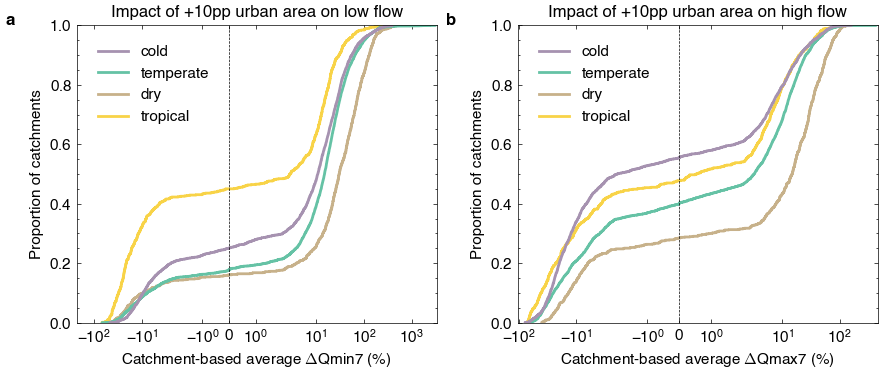

In [39]:
# ecdfplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4))
sns.ecdfplot(data = diff_Qmin7_ave, x = 'diff', hue = 'climate_label', ax = ax1, palette = palette, lw = 2)
sns.ecdfplot(data = diff_Qmax7_ave, x = 'diff', hue = 'climate_label', ax = ax2, palette = palette, lw = 2)
for i,name in enumerate(['Qmin7','Qmax7']):
    ax = eval('ax'+str(i+1))
    ax.set_xlabel('Catchment-based average $\Delta$'+name+' (%)', fontsize = 11)
    sns.move_legend(ax, 'upper left', bbox_to_anchor = (.02, .98), title = None, fontsize = 11)
    ax.set_ylabel('Proportion of catchments', fontsize = 11)
    ax.tick_params(axis = 'both', labelsize = 11)
    ax.set_xscale('symlog')
    ax.text(-.2, 1, string.ascii_letters[i], weight = 'bold', fontsize = 12, transform = ax.transAxes)
    ax.axvline(x = 0, ls = 'dashed', color = 'k', lw = .5)
    if i == 0:
        ax.set_title(f'Impact of +10pp {featureName.lower()} on low flow', fontsize = 12)
    else:
        ax.set_title(f'Impact of +10pp {featureName.lower()} on high flow', fontsize = 12)
fig.tight_layout()
fig.savefig(dir_Qmax7 / f'figure_ecdfplot_sensitivity_{feature}_{mode}.png', dpi = 600)

### importance of urban area

In [22]:
# calculate station-based average KGE and nRMSE
cols = ['pred'+str(i) for i in range(nn)]
df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label']).apply(
    lambda x: pd.Series(
        x[cols].agg(lambda y:he.kge(y.values, x.Q.values).squeeze().tolist()[0]).values.tolist() + 
        x[cols].agg(lambda y:he.kge(y.values, x.Q.values).squeeze().tolist()[1]).values.tolist() + 
        x[cols].agg(lambda y:he.kge(y.values, x.Q.values).squeeze().tolist()[2]).values.tolist() + 
        x[cols].agg(lambda y:he.kge(y.values, x.Q.values).squeeze().tolist()[3]).values.tolist() + 
        x[cols].agg(lambda y:np.sqrt(np.mean((y.values - x.Q.values)**2)) / (np.max(x.Q.values)-np.min(x.Q.values)) * 100).values.tolist() +
        x[cols].agg(lambda y:np.sqrt(np.mean((y.values - x.Q.values)**2)) / np.mean(x.Q.values) * 100).values.tolist()
    , index = [
        'KGE'+str(i) for i in range(nn)
    ] + [
        'r'+str(i) for i in range(nn)
    ] + [
        'alpha'+str(i) for i in range(nn)
    ] + [
        'beta'+str(i) for i in range(nn)
    ] + [
        'nRMSEminmax'+str(i) for i in range(nn)
    ] + [
        'nRMSEmean'+str(i) for i in range(nn)
    ])
    ).reset_index()
        
# read model performance with and without urban area
df_Qmin7 = pd.read_csv('../results/importance_of_urban_run10_Qmin7_seasonal4_multi_MSWX_meteo_MSWEP_GLEAM_simple3.csv')
df_Qmax7 = pd.read_csv('../results/importance_of_urban_run10_Qmax7_seasonal4_multi_MSWX_meteo_MSWEP_GLEAM_simple3.csv')

# calculate average values of indices
indices = df_Qmin7.columns[df_Qmin7.columns.str.contains('1')]
indices = [item[:-1] for item in indices]
for name in ['Qmin7','Qmax7']:
    for index in indices:
        eval('df_'+name)[index+'_mean'] = eval('df_'+name).loc[:,eval('df_'+name).columns.str.contains(index)].mean(axis=1)
    
df_Qmin7 = df_Qmin7.pivot_table(
    index = ['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label'],
    columns = 'mode',
    values = [item+'_mean' for item in indices]
)
df_Qmax7 = df_Qmax7.pivot_table(
    index = ['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label'],
    columns = 'mode',
    values = [item+'_mean' for item in indices]
)

# calculate difference of indices between noLULC and onlyUrban
for name in ['Qmin7','Qmax7']:
    for index in [item+'_mean' for item in indices]:
        df0 = eval('df_'+name)
        df0[index+'_diff'] = df0.loc[:,(index, 'onlyUrban')] - df0.loc[:,(index, 'noLULC')]

df_Qmin7 = df_Qmin7.reset_index()
df_Qmax7 = df_Qmax7.reset_index()

Qmin7 43.69897053603124
Qmax7 46.514380400047344


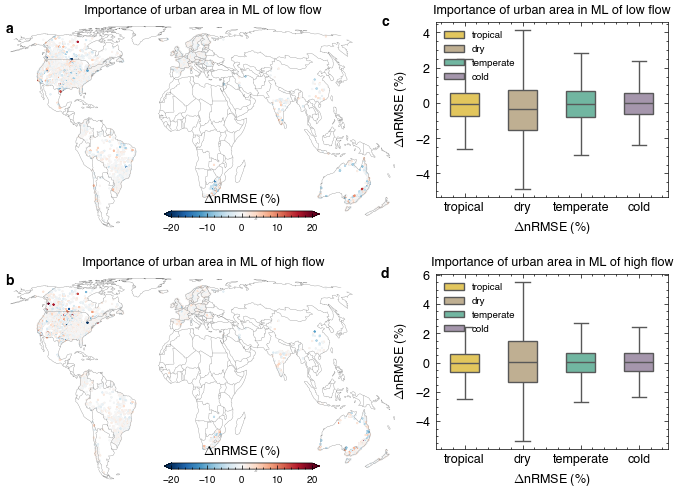

In [24]:
sss = 'nRMSEmean'

if sss == 'nRMSEmean':
    vmin = -20; vmax = 20; index = 'nRMSE (%)'
else:
    vmin = -0.2; vmax = 0.2; index = sss

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (5, 6), subplot_kw={'projection':ccrs.EqualEarth()})
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df_sta = df_Qmin7.copy()
        ax = ax1
        legend = False
        title = f'Importance of urban area in ML of low flow'
    else:
        df_sta = df_Qmax7.copy()
        ax = ax2
        legend = True
        title = f'Importance of urban area in ML of high flow'

    label = '$\Delta$' + index
    
    x = df_sta['ohdb_longitude'].values
    y = df_sta['ohdb_latitude'].values
    val = df_sta[sss+'_mean_diff'].values
    cmap = plt.cm.RdBu_r
    ras = ax.scatter(x, y, c = val, cmap = cmap, vmin = vmin, vmax = vmax, 
                    marker = "$\circ$", ec = "face", s = .3, 
                    transform = ccrs.PlateCarree())
    cax = ax.inset_axes([0.4, 0.05, 0.4, 0.03])
    fig.colorbar(ras, cax = cax, orientation = 'horizontal', extend = 'both')
    cax.set_title(label, fontsize = 9)
    
    ax.set_global()
    ax.set_ylim([-6525154.6651, 8625154.6651]) 
    ax.set_xlim([-12662826, 15924484]) 
    ax.spines['geo'].set_linewidth(0)
    ax.coastlines(linewidth = .2, color = '#707070')
    ax.add_feature(cf.BORDERS, linewidth = .2, color = '#707070')
    ax.text(0, 1, ['a','b'][i], transform = ax.transAxes, ha = 'center', va = 'top', fontsize = 10, weight = 'bold')
    ax.set_title(title, fontsize = 9)

    print(name, df_sta.loc[df_sta[f'{sss}_mean_diff']>=0.1,:].shape[0] / df_sta.shape[0] * 100)
    
ax3 = ax1.inset_axes([1.1, .15, .6, .85])
ax4 = ax2.inset_axes([1.1, .15, .6, .85])

sns.boxplot(df_Qmin7, y = sss+'_mean_diff', x = 'climate_label', hue = 'climate_label', width = .5,
            ax = ax3, palette = palette, legend = True, showfliers = False)
ax3.set_title('Importance of urban area in ML of low flow', fontsize = 9)
sns.move_legend(ax3, 'upper left', title = None)
ax3.set_xlabel(label, fontsize = 9)
ax3.tick_params(axis = 'both', labelsize = 9)
ax3.set_ylabel('$\Delta$'+index, fontsize = 9)

sns.boxplot(df_Qmax7, y = sss+'_mean_diff', x = 'climate_label', hue = 'climate_label', width = .5,
            ax = ax4, palette = palette, legend = True, showfliers = False)
ax4.set_title('Importance of urban area in ML of high flow', fontsize = 9)
sns.move_legend(ax4, 'upper left', title = None)
ax4.tick_params(axis = 'both', labelsize = 9)
ax4.set_xlabel(label, fontsize = 9)
ax4.set_ylabel('$\Delta$'+index, fontsize = 9)

ax3.text(-.2, 1, 'c', weight = 'bold', ha = 'right', va = 'center', fontsize = 10, transform = ax3.transAxes)
ax4.text(-.2, 1, 'd', weight = 'bold', ha = 'right', va = 'center', fontsize = 10, transform = ax4.transAxes)

fig.savefig(f'../picture/importance_of_{feature}_{sss}_{outName}.png', dpi = 600)


### sensitivity vs catchment area and flood size

In [2]:
df_Qmin7 = pd.read_csv('../results/sensitivity_+010urban_diff_in_percentage_xgb_Qmin7_seasonal4_multi_MSWX_meteo.csv')
df_Qmax7 = pd.read_csv('../results/sensitivity_+010urban_diff_in_percentage_xgb_Qmax7_seasonal4_multi_MSWX_meteo.csv')

df_Qmin7 = df_Qmin7.merge(
    df_Qmin7.groupby('ohdb_id').ImperviousSurface.agg(aveUrban=lambda x:x.mean(),InitUrban=lambda x:x.min()).reset_index(),
    on = 'ohdb_id'
)
df_Qmax7 = df_Qmax7.merge(
    df_Qmax7.groupby('ohdb_id').ImperviousSurface.agg(aveUrban=lambda x:x.mean(),InitUrban=lambda x:x.min()).reset_index(),
    on = 'ohdb_id'
)

In [11]:
cols = ['ohdb_id','gritDarea','aridity','aveUrban','InitUrban','BFI','runoff_ratio','climate_label','Porosity_x', 'logK_Ice_x']
df_Qmin7_ave = df_Qmin7.groupby(cols)['diff+010urban'].mean().reset_index()
df_Qmax7_ave = df_Qmax7.groupby(cols)['diff+010urban'].mean().reset_index()

df_Qmin7_cv = pd.read_csv('../results/xgb_cv10_Qmin7_seasonal4_multi_MSWX_meteo_station_based_result.csv')
df_Qmax7_cv = pd.read_csv('../results/xgb_cv10_Qmax7_seasonal4_multi_MSWX_meteo_station_based_result.csv')

df_Qmin7_ave = df_Qmin7_ave.loc[df_Qmin7_ave.ohdb_id.isin(df_Qmin7_cv.loc[df_Qmin7_cv.KGE>=0.3,'ohdb_id']),:]
df_Qmax7_ave = df_Qmax7_ave.loc[df_Qmax7_ave.ohdb_id.isin(df_Qmax7_cv.loc[df_Qmax7_cv.KGE>=0.3,'ohdb_id']),:]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,3), dpi = 200)
var = 'BFI'

for i,name in enumerate(['Qmin7','Qmax7']):
    df = eval('df_'+name)
    df = df.loc[df.season=='JJA',:]
    df['basin'] = np.where(df.aridity<=0.65, 'dry', 'wet')
    for basin in ['dry', 'wet']:
        df0 = df.loc[df.basin==basin,:]
        # get coeffs of linear fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(df0[var],df0['diff+010urban'])

        if p_value < 0.001:
            label = f"{basin:^5} y = {slope:<5.2f}x + {intercept:>5.2f}, p < 0.001" 
        else:
            label = f"{basin:^5} y = {slope:<5.2f}x + {intercept:>5.2f}, p = {p_value:<4.3f}"
        # use line_kws to set line label for legend

        color = ['r','b'][i]

        sns.regplot(x=var, 
                    y="diff+010urban", 
                    ax = eval('ax'+str(i+1)),
                    data=df0, 
                    color=color, 
                    ci = 95,
                    scatter_kws={'alpha':0.3},
                     line_kws={'label': label, 'color': color})
    eval('ax'+str(i+1)).set_ylim(None, 100)
    eval('ax'+str(i+1)).legend()

# fig.savefig('../picture/sensitivity_vs_darea_aridity_aveUrban.png', dpi = 600)

In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

# Create figure
fig = plt.figure(figsize=(10, 6))

# Parameters for ridge plots
vertical_step = 0.1  # Vertical spacing between ridges
axes_height = 0.12     # Height of each distribution's axes
left_pos = 0.1        # Left boundary for left plot
right_pos = 0.55      # Left boundary for right plot
plot_width = 0.4      # Width of each ridge plot

# Utility function to create and plot ridge axes
def create_ridge_plot(df, position, x_range, name):
    axes = []
    for i, climate in enumerate(df.climate_label.unique()):
        # Create axes for current distribution
        ax_bottom = 0.1 + i * vertical_step
        ax = fig.add_axes([position, ax_bottom, plot_width, axes_height], zorder = 10 - i)
        axes.append(ax)
        
        # Compute KDE
        sns.kdeplot(data = df.loc[df.climate_label==climate,:], 
                    x = 'diff', 
                    fill = True, 
                    hue = 'climate_label',
                    alpha = 1, 
                    ax = ax,
                    palette = palette,
                    legend = False,
                    clip = x_range)
        sns.kdeplot(data = df.loc[df.climate_label==climate,:], 
                    x = 'diff', 
                    color = 'black',
                    ax = ax,
                    palette = palette,
                    clip = x_range)
        ax.text(0.7, .5, climate, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
        ax.axvline(x=0, color='k', linestyle='dashed', linewidth=1.5)
        ax.set_ylabel(None)
        
        # add fraction symbol with positive value
        frac = df.loc[(df.climate_label==climate)&(df['diff']>0),:].shape[0] / df.loc[(df.climate_label==climate),:].shape[0] * 100
        frac = int(frac)
        print(ax_bottom + axes_height/5, str(frac))
        ax.text(0.2, ax_bottom + axes_height/5, str(frac), color='black', fontsize=13,
                ha="left", va="center", transform=ax.get_xaxis_transform())
        
        # Remove unnecessary elements
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xlim(x_range)
        
        # Only show x-axis on the bottom plot
        if i != 0:
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            ax.set_xlabel(None)
            
    # Set common x-axis for the bottom plot
    axes[0].spines['bottom'].set_visible(True)
    axes[0].xaxis.set_major_locator(ticker.AutoLocator())
    axes[0].set_xlabel(f'{name} in $\Delta$%')
    return axes

# Create both ridge plots
x_range = (-5.5, 10)  # Shared x-axis range
left_axes = create_ridge_plot(df_Qmin7, left_pos, x_range, 'Qmin7')
x_range = (-5.5, 20)
right_axes = create_ridge_plot(df_Qmax7, right_pos, x_range, 'Qmax7')

# add title
left_axes[-1].set_title('Impact of +10% urban area on Qmin7')
right_axes[-1].set_title('Impact of +10% urban area on Qmax7')

fig.savefig('../picture/ridge_plot_sensitivity_different_climate.png', dpi = 600)

# Revert back plotting style
plt.rcParams.update(plt.rcParamsDefault)  # Reset to default Matplotlib settings
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')

# Re-enable inline plotting for Jupyter
%matplotlib inline

# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
# for i,df in enumerate([df_Qmin7, df_Qmax7]):
#     g = sns.FacetGrid(df, row="climate_label", hue="climate_label", aspect=9, height=1.2, palette = palette)
#     g.map_dataframe(sns.kdeplot, x="diff", fill=True, alpha=1, clip = [-6,3])
#     g.map_dataframe(sns.kdeplot, x="diff", color='black', clip = [-6,3])
#     def label(x, color, label):
#         ax = plt.gca()
#         ax.text(0, .2, label, color='black', fontsize=13,
#                 ha="left", va="center", transform=ax.transAxes)
#         ax.axvline(x=0, color='k', linestyle='dashed', linewidth=1.5)
#         ax.set_ylabel(None)

#     g.map(label, "climate_label")
#     g.fig.subplots_adjust(hspace=-.5)
#     g.set_titles("")
#     g.set(yticks=[], xlabel="Change in flows (%)")
#     g.despine( left=True)
#     if i == 0:
#         plt.suptitle('Change in low flows due to urban expansion of 1%', y=0.98)
#     else:
#         plt.suptitle('Change in high flows due to urban expansion of 1%', y=0.98)


### plot 1D ALE plots across years

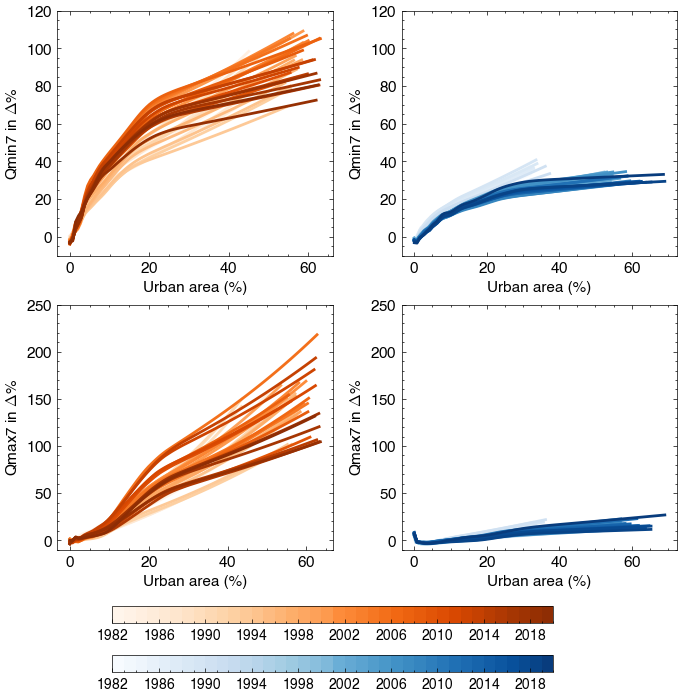

In [18]:
import pickle
from src.ale import ale,_second_order_quant_plot,_ax_quantiles,_ax_labels,_ax_title
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

fig, axes = plt.subplots(2, 2, figsize = (8, 7))
plt.subplots_adjust(hspace = .2, wspace = .25)

var = 'ImperviousSurface'

for i,name in enumerate(['Qmin7','Qmax7']):
    for j,climate in enumerate(['dry','wet']):
        ax = axes[i,j]
        if climate == 'dry':
            # Get the Blues colormap object
            blues_cmap = sns.color_palette("Oranges", as_cmap=True)
        else:
            # Get the Blues colormap object
            blues_cmap = sns.color_palette("Blues", as_cmap=True)
        # Get 40 discrete colors from the colormap
        num_colors = 40
        blues_colors_rgb = [blues_cmap(i/num_colors) for i in range(num_colors)]
        for s,year in enumerate(range(1982, 2021)):
            mc_ale0 = pickle.load(open(f'../results/mc_ale_{var}_dry_wet_{year}_xgb_{name}_seasonal4_multi_MSWX_meteo_MSWEP_GLEAM_noHydroSig_addNewAttr.pkl','rb'))
            mc_quantiles0 = pickle.load(open(f'../results/mc_quantiles_{var}_dry_wet_{year}_xgb_{name}_seasonal4_multi_MSWX_meteo_MSWEP_GLEAM_noHydroSig_addNewAttr.pkl','rb'))
        
            quantile = np.hstack([_get_centres(a) for a in mc_quantiles0[climate]])
            ale = np.hstack(mc_ale0[climate])
            tmp = pd.DataFrame({
                'ale' : ale,
                'quantile': quantile,
                'group': np.hstack([['group'+str(a)]*len(b) for a,b in enumerate(mc_ale0[climate])])
            })
            # Find common x-axis range
            min_x = tmp['quantile'].min()
            max_x = tmp['quantile'].max()
            n_sample = tmp.groupby('group')['ale'].count().min()
            x_range = np.linspace(min_x, max_x, n_sample)  # Adjust number of points as needed

            # Interpolate each group to common x-axis
            interpolated_data = {}
            for group in tmp['group'].unique():
                group_df =tmp[tmp['group'] == group]
                f = interp1d(group_df['quantile'], group_df['ale'], kind='linear', fill_value='extrapolate')
                interpolated_data[group] = pd.DataFrame({'x': x_range, 'y': f(x_range), 'group': group})

            # Concatenate interpolated data
            interpolated_df = pd.concat(interpolated_data.values())

            # Calculate average y values for each x
            df_avg = interpolated_df.groupby('x').apply(
                lambda x: pd.Series([x.y.mean(), x.y.quantile(.025), x.y.quantile(.975)], index = ['ave','low','upp'])
            ).reset_index()

            # transform ALE values from log-scale to percentage-scale
            df_avg[['ave','low','upp']] = (np.exp(df_avg[['ave','low','upp']]) -1) * 100

            # Create the lineplot with individual lines
            ax.plot(df_avg.x.values, df_avg.ave.values, color = blues_colors_rgb[s], lw = 2, label = str(year), zorder = 3)
#             ax.fill_between(
#                 df_avg.x.values, 
#                 df_avg.low.values, 
#                 df_avg.upp.values, 
#                 color = blues_colors_rgb[s], 
#                 ec = 'none',
#                 alpha = .3)
    
        ax.tick_params(axis = 'both', labelsize = 11)
        ax.set_xlabel('Urban area (%)', fontsize = 11)
        ax.set_ylabel(f'{name} in $\Delta$%', fontsize = 11)
#         ax.set_title(f'Effects of urbanization on {name} in {climate} climates', fontsize = 11)
        if i == 0:
            ax.set_ylim(-10, 120)
        else:
            ax.set_ylim(-10, 250)

        if i == 1 and j == 0:
            cax = axes[1,0].inset_axes([.2, -.3, 1.6, .07])
        if i == 1 and j == 1:
            cax = axes[1,0].inset_axes([.2, -.5, 1.6, .07])
        if i == 1:
            # create colormaps
            cmap = mpl.colors.ListedColormap(blues_colors_rgb)
            norm = mpl.colors.BoundaryNorm(np.arange(1982, 2021), cmap.N)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        
            cbar = fig.colorbar(sm, cax = cax, orientation = 'horizontal')
            cbar.ax.tick_params(labelsize=10)

fig.savefig('../picture/ale_plot_temporal_change_dry_wet.png', dpi = 600)

### plot trends of urbanization and flood

In [ ]:
df_Qmax7 = pd.read_csv('../results/xgb_cv10_Qmax7_seasonal4_multi_MSWX_meteo_raw_result.csv')
df_Qmin7 = pd.read_csv('../results/xgb_cv10_Qmin7_seasonal4_multi_MSWX_meteo_raw_result.csv')

def mk_func(x):
    mk0 = mk.original_test(x)
    return [mk0.slope, mk0.p]

df_Qmax7['climate_label'] = df_Qmax7.climate.map({1:'tropical',2:'dry',3:'temperate',4:'cold',5:'polar'})
df_Qmin7['climate_label'] = df_Qmin7.climate.map({1:'tropical',2:'dry',3:'temperate',4:'cold',5:'polar'})

df_Qmax7_mk = df_Qmax7.groupby(['ohdb_id','ohdb_longitude','ohdb_latitude','climate_label']).p_apply(
    lambda x:pd.Series(
        mk_func(x.ImperviousSurface.values) + mk_func(x.Q.values),
        index = ['slope_urban','p_urban','slope_Q','p_Q']
    )
).reset_index()
df_Qmin7_mk = df_Qmin7.groupby(['ohdb_id','ohdb_longitude','ohdb_latitude','climate_label']).p_apply(
    lambda x:pd.Series(
        mk_func(x.ImperviousSurface.values) + mk_func(x.Q.values),
        index = ['slope_urban','p_urban','slope_Q','p_Q']
    )
).reset_index()

# limit to upstream gauges
gdf = pd.read_csv('../basin_boundary/GRIT_full_catchment_all_EPSG8857_simplify_final_125km2_subset_onlyUpstream.csv')
df_Qmin7_mk = df_Qmin7_mk.loc[df_Qmin7_mk.ohdb_id.isin(gdf.ohdb_id.values),:].reset_index(drop=True)
df_Qmax7_mk = df_Qmax7_mk.loc[df_Qmax7_mk.ohdb_id.isin(gdf.ohdb_id.values),:].reset_index(drop=True)

fig, ax1 = plt.subplots(figsize = (5,3), subplot_kw = {'projection':ccrs.EqualEarth()},dpi=200)
ax2 = ax1.inset_axes([.9, 0, 1, 1], projection =  ccrs.EqualEarth())
ax2.set_facecolor('none')
for i,name in enumerate(['Qmin7','Qmax7']):
    ax = eval('ax'+str(i+1))
    ax.set_global()
    ax.set_ylim([-6525154.6651, 8625154.6651]) 
    ax.set_xlim([-12662826, 15924484]) 
    ax.spines['geo'].set_linewidth(0)
    ax.coastlines(linewidth = .2, color = '#707070')
    ax.add_feature(cf.BORDERS, linewidth = .2, color = '#707070')
    df0 = eval('df_'+name+'_mk')
    df0['type0'] = 'Others'
    df0.loc[(df0.p_urban<=0.05)&(df0.p_Q<=0.05)&(df0.slope_urban>0)&(df0.slope_Q>0),'type0'] = 'Urban+%s+'%name
    df0.loc[(df0.p_urban<=0.05)&(df0.p_Q<=0.05)&(df0.slope_urban>0)&(df0.slope_Q<0),'type0'] = 'Urban+%s-'%name
    palette1 = {'Others':'#e0e0e0','Urban+%s+'%name:'#ca3636','Urban+%s-'%name:'#364bca'}
    sns.scatterplot(
        data = df0.loc[df0.type0=='Others',:],
        x = 'ohdb_longitude',
        y = 'ohdb_latitude',
        hue = 'type0',
        transform = ccrs.PlateCarree(),
        ax = ax,
        palette = palette1,
        s = 5,
        zorder = 0
    )
    sns.scatterplot(
        data = df0.loc[df0.type0!='Others',:],
        x = 'ohdb_longitude',
        y = 'ohdb_latitude',
        hue = 'type0',
        transform = ccrs.PlateCarree(),
        ax = ax,
        palette = palette1,
        s = 5,
        zorder = 3
    )
    sns.move_legend(ax, 'upper left', bbox_to_anchor = (.5, .2), title = None, markerscale = 2, fontsize = 9)
    aa = df0.loc[df0.type0=='Urban+%s+'%name,:].shape[0] / df0.shape[0] * 100
    bb = df0.loc[df0.type0=='Urban+%s-'%name,:].shape[0] / df0.shape[0] * 100
    print('++', aa, '+-', bb)
fig.savefig('../picture/mk_trend_urban_flow.png', dpi = 600)

### plot causal treatment effects

In [ ]:
# Revert back plotting style
plt.rcParams.update(plt.rcParamsDefault)  # Reset to default Matplotlib settings
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')

# Re-enable inline plotting for Jupyter
%matplotlib inline

def compute_effsize(expGroup, controlGroup, eftype = 'cohen'):
    n1, n2 = len(expGroup), len(controlGroup)
    MAD1 = 1.4826 * np.median(np.abs(expGroup-np.median(expGroup)))
    MAD2 = 1.4826 * np.median(np.abs(controlGroup-np.median(controlGroup)))
    pooled_std = np.sqrt(((n1 - 1) * MAD1 ** 2 + (n2 - 1) * MAD2 ** 2) / (n1 + n2 - 2))
    if eftype == 'cohen':
        # d = np.mean(expGroup - controlGroup) / np.sqrt((MAD1**2+MAD2**2)/2)
        # d = np.mean(expGroup - controlGroup) / pooled_std
        d = (np.mean(expGroup) - np.mean(controlGroup)) / np.std(expGroup)
    elif eftype == 'glass':
        d = (np.mean(expGroup) - np.mean(controlGroup)) / MAD2
    return d

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 8), subplot_kw = {'projection':ccrs.EqualEarth()})
plt.subplots_adjust(hspace = .2)
ax1.set_facecolor('none')
ax2.set_facecolor('none')
for i,name in enumerate(['Qmin7','Qmax7']):
    ax = eval('ax'+str(i+1))
    df0 = eval('causal_'+name)
    df = df0.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity'])[['treatment_effects','te_lower','te_upper']].mean().reset_index()
    lons = df.ohdb_longitude.values
    lats = df.ohdb_latitude.values
    vals = df['treatment_effects'].values

    vmin, vmax, vind = np.quantile(vals, .05), np.quantile(vals, .95), 1
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)
    title = f'Treatment effect of urbanization on {name}'
    label = f'{name} in $\Delta$%'
    _, ras = plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, label, norm = norm, fontSize = 11, size = 3)
    # add colorbar
    cax = ax.inset_axes([.35, .02, 0.25, .03])
    cbar = plt.colorbar(ras, cax = cax, orientation = 'horizontal', extend = 'both')
    cax.tick_params(labelsize = 10)
    cax.set_title(label, size = 10, pad = 5)
    # add boxplot to show the impact for dry (AI<1) and wet (AI>1) catchments
    df['tmp'] = np.where(df['aridity']>6500, 'wet', 'dry')
    
    ttest = stats.ttest_ind(df.loc[df.tmp=='wet','treatment_effects'].values, df.loc[df.tmp=='dry','treatment_effects'].values)
    D = compute_effsize(df.loc[df.tmp=='wet','treatment_effects'].values, df.loc[df.tmp=='dry','treatment_effects'].values)
    
    print(ttest, D)
    
    axin = ax.inset_axes([0.08, .05, .1, .3])
    sns.boxplot(df, 
                x = 'tmp', y = 'treatment_effects', ax = axin, 
                showfliers = False, width = .7, 
                whis = [2.5, 97.5],
                color = '#c2dcea',
                showmeans = True,
                capprops = {'linewidth': 0},
                boxprops={'edgecolor': 'none'},  # No edge line
                meanprops={'marker': 'o',
                       'markerfacecolor': 'white',
                       'markeredgecolor': 'black',
                       'markersize': '4'},
                medianprops={'color': 'black', 'linewidth': 1},  # Black median line
                whiskerprops={'color': 'black', 'linewidth': 1},  # Black whiskers
               )
    axin.set_facecolor('none')
#     axin.set_yticks([0,9])
    axin.set_xlabel(None)
    axin.set_ylabel(f'{name} in $\Delta$%', fontsize = 8)
    axin.tick_params(labelsize = 8,  which='both', top = False, right = False)
    axin.spines["top"].set_visible(False) 
    axin.spines["right"].set_visible(False) 
    # add title
    ax1.set_title(title, fontsize = 10)

ax3 = ax1.inset_axes([1.1, .1, .4, .9])
ax4 = ax2.inset_axes([1.1, .1, .4, .9])
for i,name in enumerate(['Qmin7','Qmax7']):
    ax0 = [ax3,ax4][i]
    df0 = eval('causal_'+name)
    df0 = df0.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity'])[['treatment_effects','te_lower','te_upper']].mean().reset_index()
    sns.boxplot(data = df0, x = 'climate_label', y = 'treatment_effects', hue = 'climate_label', 
                showfliers = False, showmeans = True, width = .5, 
                whis = [2.5, 97.5],
                meanprops={'marker': 'o',
                           'markerfacecolor': 'white',
                           'markeredgecolor': 'black',
                           'markersize': '8'},
                ax = ax0, palette = palette)
    ax0.set_xlabel('Climate region', fontsize = 10)
    ax0.set_ylabel(f'{name} in $\Delta$%', fontsize = 10)
    ax0.tick_params(axis = 'both', labelsize = 10)
    # sns.move_legend(ax2, 'upper left', title = None, fontsize = 10)
    ax0.set_title(f'Treatment effect on {name} across climate regions', fontsize = 10)

# add subplot order
fig.text(.15, .9, 'a', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.85, .9, 'b', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.15,  .5, 'c', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.85,  .5, 'd', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)

fig.savefig(f'../picture/causal_teatment_effect_map.png', dpi = 600)

# Revert back plotting style
plt.rcParams.update(plt.rcParamsDefault)  # Reset to default Matplotlib settings
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')

# Re-enable inline plotting for Jupyter
%matplotlib inline

TtestResult(statistic=1.1876722046555923, pvalue=0.23499365223339594, df=9078.0) 0.026434059253756435


### scatterplots between SHAP/aridity and relative bias

<LAMBDA> DONE:   0%|          | 0/8614 [00:00<?, ?it/s]

<LAMBDA> DONE:   0%|          | 0/8566 [00:00<?, ?it/s]

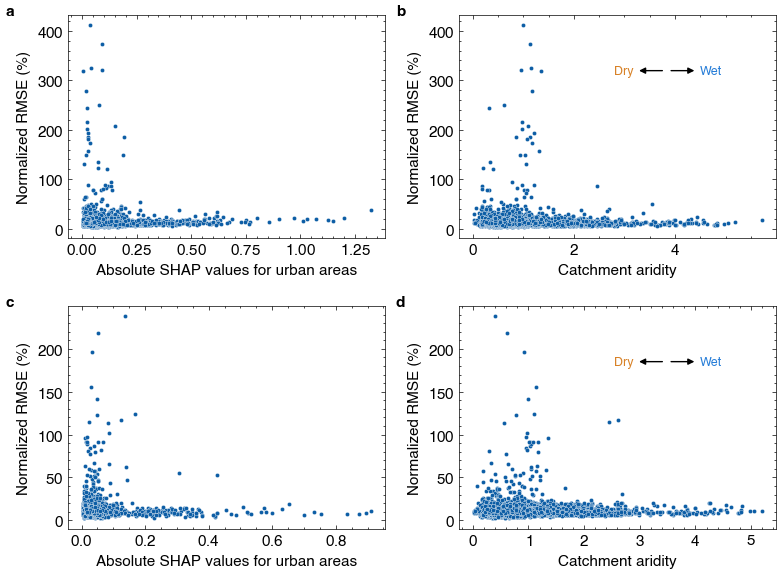

In [5]:
model = 'xgb'
mode = 'onlyUrban'
feature = 'ImperviousSurface'

df_Qmin7_cv = pd.read_csv(dir_Qmin7 / 'xgb_onlyUrban_cv10_station_based_result.csv')
df_Qmax7_cv = pd.read_csv(dir_Qmax7 / 'xgb_onlyUrban_cv10_station_based_result.csv')

df_Qmin7_shap = pd.read_pickle(dir_Qmin7 / f'{model}_{mode}_shap_values_explain_{feature}_ensemble_mean_no_outlier.pkl')
df_Qmax7_shap = pd.read_pickle(dir_Qmax7 / f'{model}_{mode}_shap_values_explain_{feature}_ensemble_mean_no_outlier.pkl')

df_attr = pd.read_csv('../data/basin_attributes.csv')

df_Qmin7_shap = df_Qmin7_shap.groupby(['ohdb_id','lon','lat','climate_label','aridity'], group_keys=False)[[feature+'_shap',feature+'_rank']].p_apply(
    lambda x:pd.Series(
        [x[feature+'_shap'].abs().mean(), x[feature+'_rank'].mean()], index = [feature+'_shap',feature+'_rank']
    )
).reset_index()
df_Qmax7_shap = df_Qmax7_shap.groupby(['ohdb_id','lon','lat','climate_label','aridity'], group_keys=False)[[feature+'_shap',feature+'_rank']].p_apply(
    lambda x:pd.Series(
        [x[feature+'_shap'].abs().mean(), x[feature+'_rank'].mean()], index = [feature+'_shap',feature+'_rank']
    )
).reset_index()

df_Qmin7 = df_Qmin7_cv.merge(df_attr[['ohdb_id','aridity']], on = 'ohdb_id').merge(
    df_Qmin7_shap[['ohdb_id',feature+'_shap']], on = 'ohdb_id')
df_Qmax7 = df_Qmax7_cv.merge(df_attr[['ohdb_id','aridity']], on = 'ohdb_id').merge(
    df_Qmax7_shap[['ohdb_id',feature+'_shap']], on = 'ohdb_id')
df_Qmin7['aridity'] = df_Qmin7['aridity'] / 10000
df_Qmax7['aridity'] = df_Qmax7['aridity'] / 10000

fig, axes = plt.subplots(2, 2, figsize = (8, 6))
for i,name in enumerate(['Qmin7','Qmax7']):
    df0 = eval('df_'+name)
    for j,name2 in enumerate([feature+'_shap','aridity']):
        ax = axes[i,j]
        sns.scatterplot(df0, y = 'nRMSEminmax', x = name2, ax = ax)
#         ax.set_xscale('log')
        ax.set_ylabel('Normalized RMSE (%)', fontsize = 11)
        if name2 == feature+'_shap':
            ax.set_xlabel('Absolute SHAP values for urban areas', fontsize = 11)
        if name2 == 'aridity':
            ax.set_xlabel('Catchment aridity', fontsize = 11)
        ax.tick_params(axis = 'both', labelsize = 11)
        ax.text(-.2, 1, string.ascii_letters[i*2+j], size = 11, transform = ax.transAxes, weight = 'bold')
        if j == 1:
            # add arrow to indicate dry/wet direction
            ax2 = ax
            ax2.annotate("Dry", xy=(.65, .75), xytext=(.55, .75),
                        arrowprops=dict(arrowstyle = '<|-', color = 'k'), va = 'center', ha = 'right',
                        textcoords = 'axes fraction', xycoords = 'axes fraction', fontsize = 9, color = '#d88228')
            ax2.annotate("Wet", xy=(.66, .75), xytext=(.76, .75),
                        arrowprops=dict(arrowstyle = '<|-', color = 'k'), va = 'center', ha = 'left',
                        textcoords = 'axes fraction', xycoords = 'axes fraction', fontsize = 9, color = '#287ed8')
fig.tight_layout()
fig.savefig(dir_Qmax7 / 'scatter_shap_aridity_nRMSE.png', dpi = 600)

In [3]:
!python xgb_flood.py --fname ../data/Qmin7_final_dataset_seasonal4.pkl --purpose ale2 --mode onlyUrban --run_dir ../results/run_Qmin7_onlyUrban_0506_1357_seed220973/

attr_name: ['BDTICM', 'elevation', 'slope', 'sedimentary', 'plutonic', 'volcanic', 'metamorphic', 'clay', 'sand', 'silt', 'Porosity_x', 'logK_Ice_x', 'year', 'climate', 'season_id', 'basin_id', 'ohdb_latitude', 'ohdb_longitude', 'res_darea_normalize', 'Year_ave', 'Main_Purpose_id', 'form_factor', 'LAI']
delta_feature: 10
device: cpu
even: False
feature: ImperviousSurface
fname: ../data/Qmin7_final_dataset_seasonal4.pkl
gpu: False
iteration: 30
log: True
lulc_name: ['ImperviousSurface']
m3s: False
meteo_name: ['p', 'tmax', 'tmin', 'swd', 'snowmelt', 'smrz']
min_interval: 0
mode: onlyUrban
model: xgb
num_workers: 8
purpose: ale2
run_dir: ../results/run_Qmin7_onlyUrban_0506_1357_seed220973
seed: 220973
target: Qmin7
n_iter: 100
n_explain: 100
Traceback (most recent call last):
  File "/data/ouce-drift/cenv1021/attribution_test/lulc_flood/xgb_flood.py", line 913, in <module>
    globals()[purpose](config)
  File "/data/ouce-drift/cenv1021/attribution_test/lulc_flood/xgb_flood.py", line 686